In [1]:
%load_ext autoreload
%autoreload 2
from tools import EnergyStorageModel

In [16]:
import numpy as np

In [27]:
# Example Usage:
model = EnergyStorageModel(eta_charge=0.98, 
                           eta_discharge=0.97, 
                           beta = 0.99,
                           a_bar = 7,
                           num_storage_levels=10,
                           num_actions=25,
                           num_price_levels=100,
                           tolerance = 1e-4,
                           max_iteration=10_000,
                           simulate_prices = False,
                           mean_reversion= 0.3,
                           p_variance = 100,
                           risk_averse=True,
                           risk_parameter=0.01)

loading data


In [26]:
V, P = model.vfi_vec() 
battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)
model.plot_results(battery_storage_sim, profit_sim, action_sim)

Starting Value Function Iteration...
Max iterations reached: 10000


In [18]:
# loop over 
from collections import defaultdict

# Create a 3D dictionary (using defaultdict)
tech_policy = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

# Initialize your parameters
N = 2
eta_chart = np.linspace(0.8, 1, N)
eta_discharge = np.linspace(0.8, 1, N)
sigma = np.linspace(0.1/100/24, 0.01, 2)

# Loop over all combinations of eta_charge, eta_discharge, and sigma
for i in range(N):
    for j in range(N):
        for k in range(2):
            print(f"eta_charge: {eta_chart[i]}, eta_discharge: {eta_discharge[j]}, sigma: {sigma[k]}")
            
            # Assign values to model parameters
            model.eta_charge = eta_chart[i]
            model.eta_discharge = eta_discharge[j]
            model.sigma = sigma[k]
            
            # Call model's method to calculate policy (V, P)
            V, P = model.vfi_vec()

            battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)
            
            # Store the policy (P) in the 3D dictionary with (eta_charge, eta_discharge, sigma) as keys
            tech_policy[eta_chart[i]][eta_discharge[j]][sigma[k]] = profit_sim[-1] #


eta_charge: 0.8, eta_discharge: 0.8, sigma: 4.1666666666666665e-05
Starting Value Function Iteration...
Converged in 32 iterations.
eta_charge: 0.8, eta_discharge: 0.8, sigma: 0.01
Starting Value Function Iteration...
Converged in 43 iterations.
eta_charge: 0.8, eta_discharge: 1.0, sigma: 4.1666666666666665e-05
Starting Value Function Iteration...
Converged in 270 iterations.
eta_charge: 0.8, eta_discharge: 1.0, sigma: 0.01
Starting Value Function Iteration...
Converged in 21 iterations.
eta_charge: 1.0, eta_discharge: 0.8, sigma: 4.1666666666666665e-05
Starting Value Function Iteration...
Converged in 251 iterations.
eta_charge: 1.0, eta_discharge: 0.8, sigma: 0.01
Starting Value Function Iteration...
Converged in 59 iterations.
eta_charge: 1.0, eta_discharge: 1.0, sigma: 4.1666666666666665e-05
Starting Value Function Iteration...
Converged in 308 iterations.
eta_charge: 1.0, eta_discharge: 1.0, sigma: 0.01
Starting Value Function Iteration...
Converged in 13 iterations.


In [ ]:
tech_policy

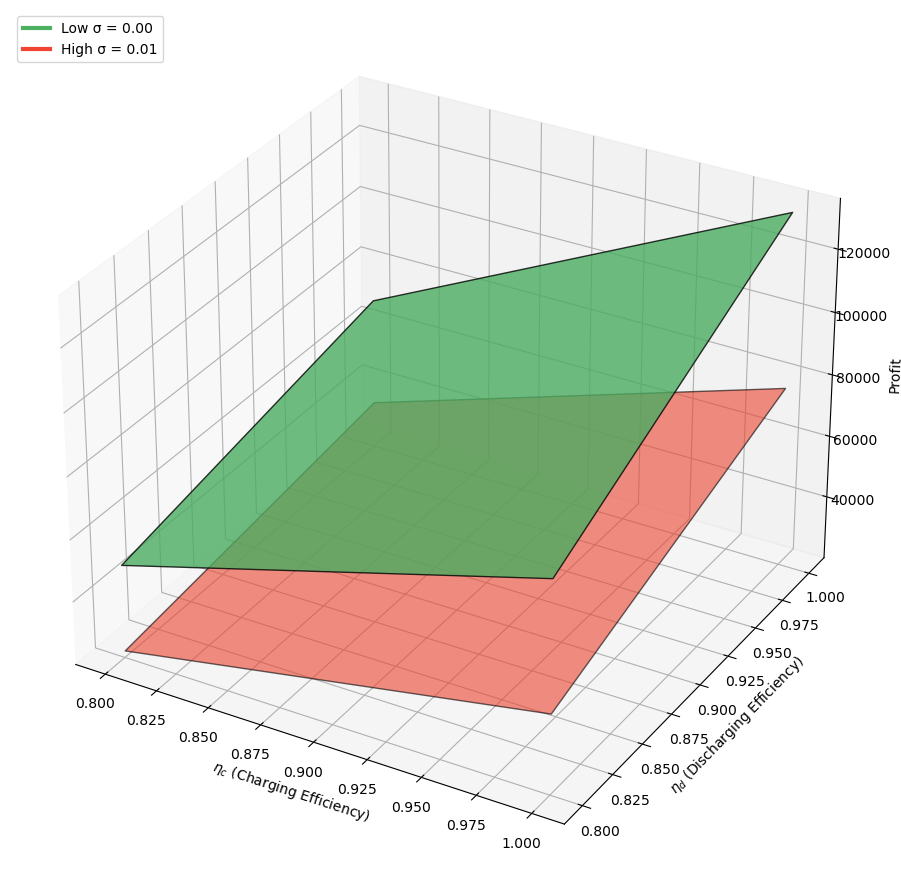

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

# Select first and last sigma
sigma_low = sigma[0]
sigma_high = sigma[-1]

# Create meshgrid
eta_grid, discharge_grid = np.meshgrid(eta_chart, eta_discharge)

# Profit values for low sigma
z_low = np.array([[tech_policy[eta_chart[i]][eta_discharge[j]][sigma_low] 
                   for j in range(N)] for i in range(N)])

# Profit values for high sigma
z_high = np.array([[tech_policy[eta_chart[i]][eta_discharge[j]][sigma_high] 
                    for j in range(N)] for i in range(N)])

# 3D Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Define solid RGBA colors and tile to match surface shape
green_color = plt.cm.Greens(0.6)
red_color = plt.cm.Reds(0.6)
green_facecolors = np.tile(green_color, (*z_low.shape, 1))
red_facecolors = np.tile(red_color, (*z_high.shape, 1))

# Plot surfaces with solid facecolors
surf1 = ax.plot_surface(
    eta_grid, discharge_grid, z_low,
    facecolors=green_facecolors, alpha=0.8, edgecolor='k'
)

surf2 = ax.plot_surface(
    eta_grid, discharge_grid, z_high,
    facecolors=red_facecolors, alpha=0.6, edgecolor='k'
)

# Labels
ax.set_xlabel(r'$\eta_c$ (Charging Efficiency)')
ax.set_ylabel(r'$\eta_d$ (Discharging Efficiency)')
ax.set_zlabel('Profit', labelpad=7)

# Custom legend
legend_elements = [
    Line2D([0], [0], color=green_color, lw=3, label=f'Low σ = {sigma_low:.2f}'),
    Line2D([0], [0], color=red_color, lw=3, label=f'High σ = {sigma_high:.2f}')
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# how do align 

In [ ]:
dropped_obs.shape

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_filter.index, df_filter['SpotPriceEUR'], label='Spot Price EUR')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.title('Spot Prices Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Reduce x-axis labels for clarity
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))

plt.grid(True)
plt.show()

In [ ]:
import numpy as np

def compute_price_transitions(df, num_price_levels):
    prices = df["SpotPriceEUR"].values
    price_grid = np.linspace(prices.min(), prices.max(), num_price_levels)
    
    price_transitions = np.zeros((num_price_levels, num_price_levels))
    price_indices = np.array([np.argmin(np.abs(price_grid - p)) for p in prices])

    assert np.unique(price_indices).size == num_price_levels, "Not all price indices are observed in data."

    for t in range(len(price_indices) - 1):
        i = price_indices[t]
        j = price_indices[t + 1]
        price_transitions[i, j] += 1

    # Normalize rows
    row_sums = price_transitions.sum(axis=1, keepdims=True)
    price_transitions = np.divide(price_transitions, row_sums, where=row_sums != 0)
    assert np.allclose(price_transitions.sum(axis=1), 1), "Not all rows sum to 1."

    return price_transitions, price_grid

num_price_levels = 20
price_trans, price_grid = compute_price_transitions(df_filter,num_price_levels)
price_trans

In [ ]:

# Select indices for the prices you want to plot
selected_indices = [0, num_price_levels // 3, 2 * num_price_levels // 3, num_price_levels - 1]

# Plotting
plt.figure(figsize=(10, 6))

for idx in selected_indices:
    color = plt.cm.viridis(idx / num_price_levels)  # Use color map to differentiate
    plt.plot(price_grid, price_trans[idx], label=f"Today: {price_grid[idx]:.2f} EUR", color=color)
    # Add dashed vertical line at selected price level
    plt.axvline(x=price_grid[idx], color=color, linestyle='--', linewidth=1)


plt.title("Price Transition Probabilities")
plt.xlabel("Price Tomorrow (EUR)")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ETA HIGH

In [ ]:
# Example Usage:
model = EnergyStorageModel(eta_charge=0.98, 
                           eta_discharge=0.97, 
                           beta = 0.99,
                           a_bar = 1,
                           num_storage_levels=10,
                           num_actions=25,
                           num_price_levels=50,
                           tolerance = 1e-4,
                           max_iteration=10_000,
                           simulate_prices = False,
                           mean_reversion= 0.3,
                           p_variance = 100,
                           risk_averse=True,
                           risk_parameter=0.01,
                           )